In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
sns.set_theme()
tqdm.pandas()

In [2]:
df_train = pd.read_csv("../../data/original_dataset/original_train_data.csv")
df_eval = pd.read_csv("../../data/original_dataset/original_val_data.csv")
df_test = pd.read_csv("../../data/original_dataset/original_test_data.csv")

## Training data without OOS for the initial clustering:

In [3]:
df_train_no_oos = df_train[df_train.label!="oos"]

In [4]:
df_train.shape, df_train_no_oos.shape

((15100, 2), (15000, 2))

In [5]:
df_train.label.value_counts()

shopping_list                100
exchange_rate                100
time                         100
current_location             100
change_ai_name               100
                            ... 
definition                   100
international_visa           100
replacement_card_duration    100
who_made_you                 100
next_song                    100
Name: label, Length: 151, dtype: int64

# Sentence Transformers - MPNET

In [6]:
mpnet = SentenceTransformer("all-mpnet-base-v2")

In [7]:
sentence_embeddings = []
embedding_matrix = mpnet.encode(df_train_no_oos["query"].values)
for i in range(embedding_matrix.shape[0]):
  sentence_embeddings.append(embedding_matrix[i])  

df_train_no_oos["mpnet_embeddings_sentence"] = sentence_embeddings

<ipython-input-7-fb4de2061ae3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_no_oos["mpnet_embeddings_sentence"] = sentence_embeddings


# Clustering with 150 clusters for 150 intents

In [9]:
(df_train_no_oos["mpnet_embeddings_sentence"].values).shape

(15000,)

In [10]:
X = embedding_matrix
kmeans = KMeans(n_clusters=150, random_state=0)
clusters = kmeans.fit_predict(X)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Get distribution of each cluster

In [11]:
df_train_no_oos["cluster"] = clusters

<ipython-input-11-ed4596975abd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_no_oos["cluster"] = clusters


In [31]:
df_train_no_oos.groupby("cluster")["label"].value_counts(normalize=True)[:20]

cluster  label                    
0        tire_change                  0.980198
         last_maintenance             0.009901
         schedule_maintenance         0.009901
1        pto_request                  0.537037
         pto_request_status           0.444444
         pto_balance                  0.018519
2        redeem_rewards               0.942308
         rewards_balance              0.038462
         new_card                     0.019231
3        replacement_card_duration    1.000000
4        reminder_update              0.472973
         reminder                     0.243243
         cancel                       0.040541
         share_location               0.040541
         timer                        0.040541
         goodbye                      0.027027
         balance                      0.013514
         bill_balance                 0.013514
         income                       0.013514
         meal_suggestion              0.013514
Name: label, dtype: float

In [13]:
df_train_no_oos.groupby("label")["cluster"].value_counts(normalize=True)

label                cluster
accept_reservations  68         0.98
                     21         0.01
                     108        0.01
account_blocked      47         0.97
                     109        0.02
                                ... 
yes                  48         0.58
                     108        0.36
                     137        0.03
                     111        0.02
                     4          0.01
Name: cluster, Length: 512, dtype: float64

In [14]:
df_train_no_oos.iloc[0]

query                                    what products are on my shopping list
label                                                            shopping_list
mpnet_embeddings_sentence    [0.054108698, -0.022276683, 0.002722802, -0.00...
cluster                                                                     22
Name: 0, dtype: object

In [15]:
kmeans.transform(mpnet.encode([df_train_no_oos["query"].iloc[0]]))

array([[1.282259  , 1.1918143 , 1.1550746 , 1.2472636 , 0.993345  ,
        1.1745578 , 1.1882201 , 1.1133975 , 1.1683555 , 1.1188431 ,
        1.1589363 , 1.0857171 , 1.1826276 , 1.2595925 , 1.1900183 ,
        1.1143723 , 1.2211809 , 1.1039914 , 1.0242587 , 1.1187304 ,
        1.2573937 , 1.1292385 , 0.42142203, 1.1364903 , 1.2576085 ,
        1.1875852 , 1.1497083 , 1.2797967 , 1.1222352 , 1.163643  ,
        1.24705   , 1.1737405 , 1.1886344 , 1.1892498 , 1.1536143 ,
        1.2047955 , 1.1553203 , 1.2167102 , 1.3195615 , 1.1693119 ,
        1.0379696 , 1.0076298 , 1.201972  , 1.1093078 , 1.2091751 ,
        1.251933  , 1.2091292 , 1.1937691 , 1.2233648 , 1.1416177 ,
        1.1242657 , 1.0380611 , 1.1309012 , 1.132996  , 1.1363591 ,
        1.1988082 , 1.0682591 , 0.99840283, 1.2255784 , 0.9044398 ,
        1.2370925 , 1.1354269 , 1.2715404 , 1.2548178 , 1.1216071 ,
        1.1799694 , 1.2664981 , 1.1991059 , 1.17154   , 1.2346119 ,
        1.1404157 , 1.1134758 , 1.1491339 , 1.25

In [16]:
def compute_distance_of_closest_cluster(df):
    cluster_distances = kmeans.transform(mpnet.encode(df["query"].values))
    cluster_min_distances = cluster_distances.min(axis=1)
    df["min_distances"] = cluster_min_distances
    

In [17]:
compute_distance_of_closest_cluster(df_train_no_oos)

<ipython-input-16-fdf4798851b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["min_distances"] = cluster_min_distances


Text(0.5, 1.0, 'Distance to closest centres for in-scope intent queries')

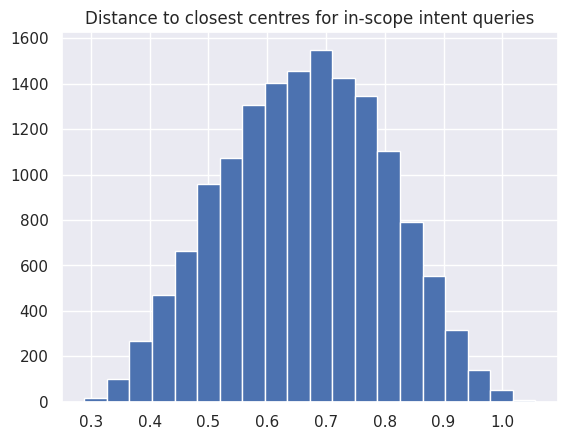

In [18]:
df_train_no_oos.min_distances.hist(bins=20)
plt.title("Distance to closest centres for in-scope intent queries")

In [19]:
df_train_oos = df_train[df_train.label=="oos"]

<ipython-input-16-fdf4798851b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["min_distances"] = cluster_min_distances


Text(0.5, 1.0, 'Distance to closest centres for out-of-scope intent queries')

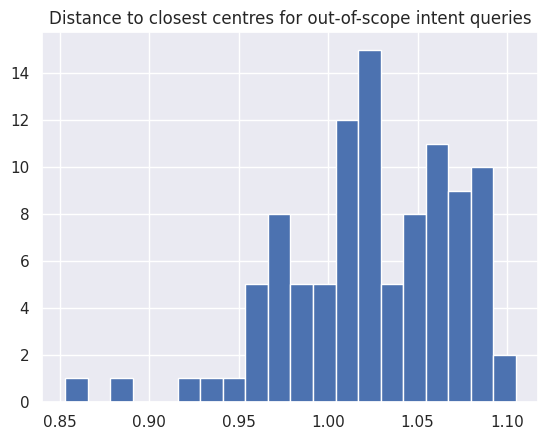

In [20]:
compute_distance_of_closest_cluster(df_train_oos)
df_train_oos.min_distances.hist(bins=20)
plt.title("Distance to closest centres for out-of-scope intent queries")

In [21]:
df_train_oos

,query,label,min_distances
142,when was nintendo created,oos,1.009350
411,can you help me study for a history exam,oos,0.982383
472,what is the highest earning game on atari,oos,1.064957
675,who is the scariest character in start trek,oos,1.063868
842,where is the dipstick,oos,1.014657
...,...,...,...
14418,what is the next football game,oos,1.015986
14472,how many oscars did star wars films win,oos,1.050834
14897,what's the best price on super smash bros ulti...,oos,1.028082
14900,who's toledo's starting point guard for the ne...,oos,1.024270


# Evaluating approach - OOS Recall

In [22]:
THRESHOLD = 0.95

In [23]:
compute_distance_of_closest_cluster(df_eval)

In [24]:
df_eval["pred"] = df_eval.min_distances.apply(lambda x: "oos" if x>THRESHOLD else "in-scope")

In [25]:
df_eval

,query,label,min_distances,pred
0,my account looks to be blocked and i have no i...,account_blocked,0.707956,in-scope
1,what are my recent purchases,transactions,0.650560,in-scope
2,"if i plan on travelling to this country, do i ...",international_visa,0.711531,in-scope
3,mark my calendar that i will be meeting steven...,calendar_update,0.836456,in-scope
4,i couldn't say,maybe,0.799254,in-scope
...,...,...,...,...
3095,i need a spider fact,fun_fact,0.780972,in-scope
3096,i'm sorry please repeat the question,repeat,0.820536,in-scope
3097,i prefer to be called jason,change_user_name,0.686378,in-scope
3098,dial the last number that called me,make_call,0.709285,in-scope


In [26]:
df_eval["binary_label"] =  df_eval.label.apply(lambda x: "oos" if x=="oos" else "in-scope")

In [27]:
pd.DataFrame(classification_report(df_eval["binary_label"], df_eval["pred"], output_dict=True)).T

,precision,recall,f1-score,support
in-scope,0.996281,0.982333,0.989258,3000.000000
oos,0.626761,0.890000,0.735537,100.000000
accuracy,0.979355,0.979355,0.979355,0.979355
macro avg,0.811521,0.936167,0.862398,3100.000000
weighted avg,0.984361,0.979355,0.981074,3100.000000


# Results on test set:

In [28]:
compute_distance_of_closest_cluster(df_test)

In [29]:
df_test["pred"] = df_test.min_distances.apply(lambda x: "oos" if x>THRESHOLD else "in-scope")
df_test["binary_label"] =  df_test.label.apply(lambda x: "oos" if x=="oos" else "in-scope")

In [30]:
pd.DataFrame(classification_report(df_test["binary_label"], df_test["pred"], output_dict=True)).T

,precision,recall,f1-score,support
in-scope,0.950548,0.982444,0.966233,4500.000000
oos,0.906949,0.770000,0.832883,1000.000000
accuracy,0.943818,0.943818,0.943818,0.943818
macro avg,0.928749,0.876222,0.899558,5500.000000
weighted avg,0.942621,0.943818,0.941988,5500.000000


As we can see, compared to the baseline results presented in the paper, this clustering algorithm performs much better, with an OOS recall of 0.77 as opposed to ~0.60 presented in the paper.

# What if we predict the class directly instead of just the binary task of whether an intent is in-scope or OOS?

## Assign each cluster to be associated with its most common intent:

In [43]:
cluster_id_to_intent = dict(df_train_no_oos.groupby("cluster")["label"].agg(pd.Series.mode))

In [44]:
cluster_id_to_intent

{0: 'tire_change',
 1: 'pto_request',
 2: 'redeem_rewards',
 3: 'replacement_card_duration',
 4: 'reminder_update',
 5: 'alarm',
 6: 'lost_luggage',
 7: 'bill_balance',
 8: 'change_language',
 9: 'what_song',
 10: 'current_location',
 11: 'calendar_update',
 12: 'credit_limit',
 13: 'direct_deposit',
 14: 'pto_balance',
 15: array(['international_visa', 'vaccines'], dtype=object),
 16: 'oil_change_how',
 17: 'repeat',
 18: 'meal_suggestion',
 19: 'what_is_your_name',
 20: 'meaning_of_life',
 21: 'restaurant_reservation',
 22: 'shopping_list',
 23: 'book_flight',
 24: 'mpg',
 25: 'routing',
 26: 'income',
 27: 'change_volume',
 28: 'what_are_your_hobbies',
 29: 'insurance',
 30: 'flip_coin',
 31: 'traffic',
 32: 'who_do_you_work_for',
 33: 'improve_credit_score',
 34: 'are_you_a_bot',
 35: 'last_maintenance',
 36: 'time',
 37: 'jump_start',
 38: 'rollover_401k',
 39: 'change_speed',
 40: 'update_playlist',
 41: 'ingredients_list',
 42: 'find_phone',
 43: 'user_name',
 44: 'interest_rate

In [45]:
cluster_id_to_intent[15] = cluster_id_to_intent[15][0] # Because there are 2 values for cluster 15

In [50]:
print(f"Unique intents in the 150 clusters: {len(set(cluster_id_to_intent.values()))}")

Unique intents in the 150 clusters: 140


In [53]:
def assign_clusters_and_predict(df):
    clusters = kmeans.predict(mpnet.encode(df["query"].values))
    df["cluster"] = clusters
    df["cluster_prediction"] = df["cluster"].apply(lambda x: cluster_id_to_intent[x])
    

In [54]:
assign_clusters_and_predict(df_eval)

In [56]:
pd.DataFrame(classification_report(df_eval["label"], df_eval["cluster_prediction"], output_dict=True)).T

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
accept_reservations,0.869565,1.000000,0.930233,20.00
account_blocked,1.000000,1.000000,1.000000,20.00
alarm,1.000000,1.000000,1.000000,20.00
application_status,0.500000,1.000000,0.666667,20.00
apr,1.000000,1.000000,1.000000,20.00
...,...,...,...,...
who_made_you,0.645161,1.000000,0.784314,20.00
yes,0.684211,0.650000,0.666667,20.00
accuracy,0.820000,0.820000,0.820000,0.82
macro avg,0.802782,0.841722,0.806951,3100.00


Since the accuracy is quite low compared to the baseline models presented in the paper, we do not continue with this method, and istead use the clustering only for the OOS predictions. 